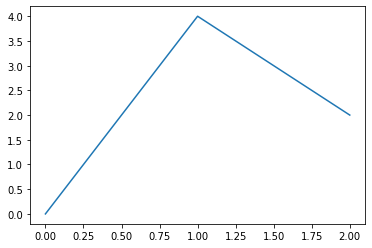

In [1]:
import matplotlib.pyplot as plt

plt.plot([0,1,2], [0,4,2])
plt.show()

In [2]:
from random import random, randint
import numpy as np
from classes import Bandit

import torch
from torch import nn, optim
from torch.nn import functional
from torch.autograd import Variable
from math import log

import matplotlib.pyplot as plt

class a2c_network(nn.Module):
    """
    This class defines an Advantage Actor-Critic network implemented in Pytorch
    """
    
    def __init__(self, N_arms, state_dim, actor_layers, critic_layers, learning_rate ):
        super(a2c_network, self).__init__()
        
        self.actor = [ nn.Linear(state_dim, actor_layers[0]) ]
        for i in range(len(actor_layers)-1):
            self.actor.append( nn.Linear(actor_layers[i], actor_layers[i+1]) )
        self.actor.append( nn.Linear(actor_layers[-1], N_arms) )
        
        for i, layer in enumerate(self.actor):
            setattr(self, "actor"+str(i), layer)
        
        self.critic = [ nn.Linear(state_dim, critic_layers[0]) ]
        for i in range(len(critic_layers)-1):
            self.critic.append( nn.Linear(critic_layers[i], critic_layers[i+1]) )
        self.critic.append( nn.Linear(critic_layers[-1], 1) )
        
        for i, layer in enumerate(self.critic):
            setattr(self, "critic"+str(i), layer)
        
        
        
    def forward(self, state):
        """
        Returns an expected value and recommended policy for a given state
        """
        policy = functional.relu(self.actor[0](state))
        for i in range(1, len(self.actor)-1):
            policy = functional.relu( self.actor[i](policy) )
        policy = functional.softmax( self.actor[-1](policy), dim=1)
        
        value = functional.relu(self.critic[0](state))
        for i in range(1, len(self.critic)-1):
            value = functional.relu( self.critic[i](value) )
        value = self.critic[-1](value) 
        
        return value, policy

def init_a2c(B, kwargs):
    """
    Initializes an Advantage Actor-Critic (A2C) agent
    """
    B.state = env.reset()
    B.state = B.state.reshape(1,B.state.shape[0])
    B.state = torch.FloatTensor( B.state )
    B.done = False
    
    B.N_arms = kwargs['N_arms'] 
    B.lr = kwargs['lr']
    B.discount = kwargs['discount']
    B.maxlen = kwargs['maxlen']
    
    B.Q = []
    B.logP = []
    B.history = []
    B.values = []
    B.policies = []
    B.entropy = 0
    
    B.model = a2c_network( B.N_arms, B.state.shape[1], kwargs['actor_layers'], kwargs['critic_layers'], kwargs['lr'])
    B.optim = optim.Adam( B.model.parameters(), lr = B.lr)
    

def a2c(B):
    """
    Selects policy from a weighted distribution calculated by the agent from the current state 
    """
    value, policy = B.model.forward( B.state )
    B.pdist = policy
    B.values.append( value.detach().numpy()[0][0] )
    B.policies.append( np.squeeze( policy.detach().numpy() ) )
    return np.random.choice( B.N_arms, p=B.policies[-1] )


def update_a2c(B, arm, reward, observation):
    """
    Updates the agent based on the most recent action and reward using the Advantage Actor-Critic (A2C) method
    """
    observation = observation.reshape(1, observation.shape[0])
    observation = torch.FloatTensor(observation)
    B.history.append( (B.state, arm, reward, observation) )
    B.state = observation
    
    B.logP.append( torch.log(B.pdist.squeeze(0)[arm]) )
    B.entropy -= np.sum( np.mean(B.policies[-1]) * np.log(B.policies[-1]) )
    
    if B.done or len(B.history) == B.maxlen:
        Q0, useless = B.model.forward( observation )
        Q0 = Q0.detach().numpy()[0][0]
        
        N = len(B.history)
        B.Q = [ Q0 for n in range(N) ]
        for i in range(N-1, 1, -1):
            B.Q[i-1] = B.history[i-1][2] + B.Q[i] * B.discount
        
        logP = torch.stack(B.logP)
        Q = torch.FloatTensor(B.Q)
        V = torch.FloatTensor( B.values )
        
        A = Q - V
        a_loss = ( -logP * A ).mean()
        c_loss = 0.5 * (A.pow(2)).mean()
        loss = a_loss + c_loss - 0.001*B.entropy 
        
        B.optim.zero_grad()
        loss.backward()
        B.optim.step()
        
        B.Q = []
        B.logP = []
        B.history = []
        B.values = []
        B.policies = []
        B.entropy = 0
        
    return


The following cell uses the functions above to create an A2C bandit and trains it on the defined environment

In [ ]:
import gym

#env = gym.make("CartPole-v0")
env = gym.make('LunarLander-v2')
env.reset()

kwargs = { "N_arms": env.action_space.n, "discount": 0.99, "lr": 0.0003, "actor_layers": [256], "critic_layers": [256], "maxlen": 10000}

# Creates a multi-armed bandit using the defined A2C functions and parameters
B = Bandit(env, a2c, update_a2c, init_a2c, kwargs )


# Initialize variables to track iterations, rewards and weights
counter = 0
best_return = -200
rewards = []
all_weights = []

# Sets the number of iterations and interval to print average reward (never prints if set to None)
N_iterations = 5000
interval = None

# Toggles whether the animation of the environment is rendered during training
render = False

for i in range(N_iterations):
    
    done = False
    counter += 1
    if interval is not None and counter%interval == 0:
        print( counter, "\t", sum(rewards[-interval:])/float(interval) )
    total_return = 0
    env.reset()
    j = 0
    while not done:
        if render:
            env.render()
        arm = B.policy(B)
        observation, reward, done, info = env.step(arm)
        B.done = done
        j += 1
        B.update(B, arm, reward, observation )
        total_return += reward
        if done:
            rewards.append( total_return )
            env.reset()
            if total_return > best_return:
                best_return = total_return
            break

env.reset()
env.close()
print( "Finished after ", counter, " episodes with a top score of", best_return )

Plot the reward over time along with a smoothed rolling average

In [ ]:
%matplotlib inline

def average(arr, i, window):
    return sum(rewards[i-window:i+window])/float(2*window)

window = 5
smoothed = [ average(rewards, i, window) for i in range(window,len(rewards)-window) ]

fig, ax = plt.subplots( figsize=(10,5) )
ax.plot( rewards )
ax.plot( smoothed, c='red' )
fig.patch.set_facecolor('white')
ax.set_ylim(-300,100)
plt.show()

The following cell records a video of the (now trained) agent as it attempts a specified number of trials 

In [ ]:
from gym import wrappers

recorder = wrappers.monitoring.video_recorder.VideoRecorder(env, 'C:/Users/Zeyad/Desktop/Reinforcement Learning/videos/lunar_lander_a2c.mp4')

N_trials = 1
for i in range(N_trials):
    done = False
    total_return = 0
    while not done:
        env.render()
        arm = B.policy(B)
        observation, reward, done, info = env.step(arm)
        B.update(B, arm, reward, observation)
        total_return += reward
        recorder.capture_frame()
        if done:
            rewards.append( total_return )
            env.reset()
            recorder.close()
            recorder.Enabled = False
            best_return = total_return
            break
env.close()

print( rewards[-10:] )